# From reads and insertions to essentiality prediction using a Regression Model

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [12]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_data_insertions="Python_scripts/Data_Files/wt-truncated-insertions-per-gene.txt"
rel_path_data_reads="Python_scripts/Data_Files/wt-truncated-reads-per-gene.txt"


abs_path_data_reads = os.path.join(script_dir, rel_path_data_reads)
abs_path_data_insertions = os.path.join(script_dir, rel_path_data_insertions)

# os.chdir('../') #<-- for binder os.chdir('../')


In [13]:

data_insertions = pd.read_csv(abs_path_data_insertions, sep="\t", header=0)

data_reads = pd.read_csv(abs_path_data_reads, sep="\t", header=0)

In [16]:
data_reads_pd=data_reads.iloc[:,0:3]
data_reads_pd.columns=['Gene_name','Essentiality','reads-truncated']
data_reads_pd.head()

Gene_name  Essentiality  reads-truncated
0    YAL069W             0              123
1  YAL068W-A             0               22
2       PAU8             0               14
3  YAL067W-A             0                0
4       SEO1             0               88

In [17]:
data_insertions_pd=data_insertions.iloc[:,0:3]
data_insertions_pd.columns=['Gene_name','Essentiality','insertions-truncated']
data_insertions_pd.head()

Gene_name  Essentiality  insertions-truncated
0    YAL069W             0                     5
1  YAL068W-A             0                     2
2       PAU8             0                     1
3  YAL067W-A             0                     0
4       SEO1             0                    15

In [18]:
data=data_reads_pd.copy()
data['insertions']=data_insertions_pd['insertions-truncated']


In [19]:
data

Gene_name  Essentiality  reads-truncated  insertions
0       YAL069W             0              123           5
1     YAL068W-A             0               22           2
2          PAU8             0               14           1
3     YAL067W-A             0                0           0
4          SEO1             0               88          15
...         ...           ...              ...         ...
6595       ARR3             0              265           7
6596    YPR202W             0               19          18
6597    YPR203W             0               12           8
6598    YPR204W             0               11          66
6599  YPR204C-A             0                4           4

[6600 rows x 4 columns]

## Visualising how the input data is distributed regarding the type of essentiality of the genes

Text(0.5, 1.0, 'Outliers-viz')

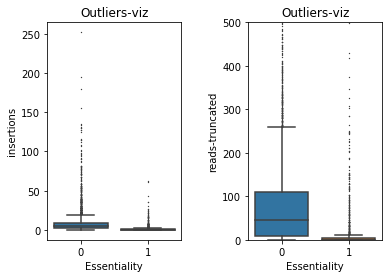

In [34]:
fig, axes=plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
sns.boxplot(x='Essentiality',y='insertions',data=data,ax=axes[0],fliersize=0.5)
# sns.boxplot(x='Essentiality',y='insertions-non-truncated',data=data,ax=axes[0])
# axes[0].set_ylim([0,100])
sns.boxplot(x='Essentiality',y='reads-truncated',data=data,ax=axes[1],fliersize=0.5)
axes[1].set_ylim([0,500])
axes[0].set_title('Outliers-viz')
axes[1].set_title('Outliers-viz')

## Remove outliers 

Text(0.5, 1.0, 'Outliers-viz')

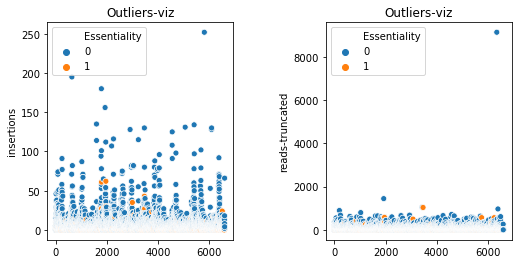

In [33]:
fig, axes=plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5,right=1.2)
sns.scatterplot(y='insertions',x=np.arange(0,len(data)),data=data,hue='Essentiality',ax=axes[0])
# plt.ylim([0,20])
sns.scatterplot(y='reads-truncated',x=np.arange(0,len(data)),data=data,hue='Essentiality',ax=axes[1])
axes[0].set_title('Outliers-viz')
axes[1].set_title('Outliers-viz')

### Make use of the IQR to remove the outliers

- IQR is part of Descriptive statistics and also called as midspead , middle 50%

- IQR is first Quartile minus the Third Quartile (Q3-Q1)

In [74]:
y_insert_non_essential=data[data['Essentiality']==0]['insertions']
removed_outliers_insertions_nE = y_insert_non_essential.between(y_insert_non_essential.quantile(.05), y_insert_non_essential.quantile(.95)) # any value bellow  Q1-0.05*IQR or above Q3+0.95*IQR is an outl

y_insert_essential=data[data['Essentiality']==1]['insertions']
removed_outliers_insertions_E = y_insert_essential.between(y_insert_essential.quantile(.05), y_insert_essential.quantile(.9)) # any value bellow  Q1-0.05*IQR or above Q3+0.95*IQR is an outl

In [75]:
y_reads_non_essential=data[data['Essentiality']==0]['reads-truncated']
removed_outliers_reads_nE = y_reads_non_essential.between(y_reads_non_essential.quantile(.05), y_reads_non_essential.quantile(.95)) # any value bellow  Q1-0.05*IQR or above Q3+0.95*IQR is an outl

y_reads_essential=data[data['Essentiality']==1]['reads-truncated']
removed_outliers_reads_E = y_reads_essential.between(y_reads_essential.quantile(.05), y_reads_essential.quantile(.9)) # any value bellow  Q1-0.05*IQR or above Q3+0.95*IQR is an outl

Text(0, 0.5, 'Reads after truncation-E')

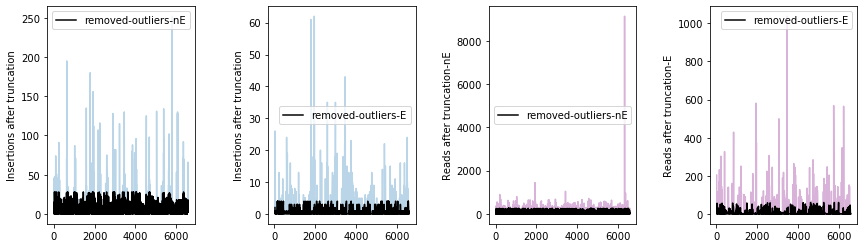

In [76]:
fig, axes=plt.subplots(1,4)
plt.subplots_adjust(wspace=0.5,right=2)

axes[0].plot(y_insert_non_essential,alpha=0.3)
axes[0].plot(y_insert_non_essential[removed_outliers_insertions_nE],label='removed-outliers-nE',color='black')
axes[0].legend()
axes[0].set_ylabel('Insertions after truncation')
axes[1].plot(y_insert_essential,alpha=0.3)
axes[1].plot(y_insert_essential[removed_outliers_insertions_E],label='removed-outliers-E',color='black')
axes[1].legend()
axes[1].set_ylabel('Insertions after truncation')

axes[2].plot(y_reads_non_essential,alpha=0.3,color='purple')
axes[2].plot(y_reads_non_essential[removed_outliers_reads_nE],label='removed-outliers-nE',color='black')
axes[2].legend()
axes[2].set_ylabel('Reads after truncation-nE')

axes[3].plot(y_reads_essential,alpha=0.3,color='purple')
axes[3].plot(y_reads_essential[removed_outliers_reads_E],label='removed-outliers-E',color='black')
axes[3].legend()
axes[3].set_ylabel('Reads after truncation-E')

In [77]:
data[data['Essentiality']==0]['insertions-non-outliers']=y_insert_non_essential[removed_outliers_insertions_nE]
data[data['Essentiality']==1]['insertions-non-outliers']=y_insert_essential[removed_outliers_insertions_E]
data[data['Essentiality']==0]['reads-non-outliers']=y_reads_non_essential[removed_outliers_reads_nE]
data[data['Essentiality']==1]['reads-non-outliers']=y_reads_essential[removed_outliers_reads_E]

Text(0.5, 1.0, 'original')

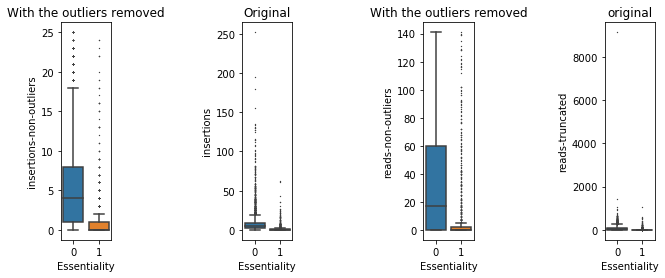

In [98]:
fig, axes=plt.subplots(1,4)
plt.subplots_adjust(wspace=2.6,right=1.5)

data.fillna(0,inplace=True)
sns.boxplot(x='Essentiality',y='insertions-non-outliers',data=data,ax=axes[0],fliersize=0.5)
axes[0].set_title('With the outliers removed')
sns.boxplot(x='Essentiality',y='insertions',data=data,ax=axes[1],fliersize=0.5)
axes[1].set_title('Original')
sns.boxplot(x='Essentiality',y='reads-non-outliers',data=data,ax=axes[2],fliersize=0.5)
axes[2].set_title('With the outliers removed')
sns.boxplot(x='Essentiality',y='reads-truncated',data=data,ax=axes[3],fliersize=0.5)
axes[3].set_title('original')


In [79]:
data_remove_outliers=data.copy()
# data_remove_outliers=data_remove_outliers.drop(columns=['reads-non-truncated','insertions-non-truncated'])
data_remove_outliers.fillna(0,inplace=True)

In [80]:
data_remove_outliers.head()

Gene_name  Essentiality  reads-truncated  insertions  \
0    YAL069W             0              123           5   
1  YAL068W-A             0               22           2   
2       PAU8             0               14           1   
3  YAL067W-A             0                0           0   
4       SEO1             0               88          15   

   insertions-non-outliers  reads-non-outliers  
0                      5.0               123.0  
1                      2.0                22.0  
2                      1.0                14.0  
3                      0.0                 0.0  
4                     15.0                88.0

In [81]:
data_remove_outliers.groupby('Essentiality').describe()

reads-truncated                                                \
                       count       mean         std  min  25%   50%    75%   
Essentiality                                                                 
0                     5414.0  79.477096  159.159200  0.0  9.0  45.0  109.0   
1                     1186.0  20.420742   64.925943  0.0  0.0   0.0    5.0   

                     insertions            ... insertions-non-outliers        \
                 max      count      mean  ...                     75%   max   
Essentiality                               ...                                 
0             9134.0     5414.0  8.267270  ...                     8.0  25.0   
1             1037.0     1186.0  1.704047  ...                     1.0  24.0   

             reads-non-outliers                                              \
                          count       mean        std  min  25%   50%   75%   
Essentiality                                                                  
0                        5414.0  34.514407  40.064659  0.0  0.0  17.0  60.0   
1                        1186.0   9.588533  24.263657  0.0  0.0   0.0   2.0   

                     
                max  
Essentiality         
0             141.0  
1             141.0  

[2 rows x 32 columns]

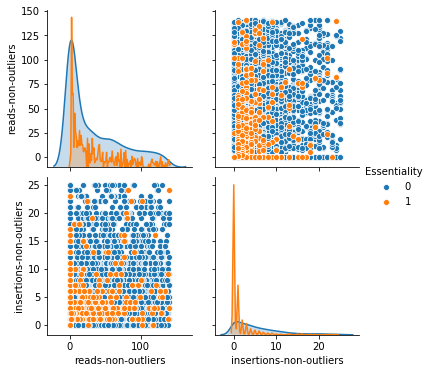

In [82]:
sns.pairplot(data=data_remove_outliers,hue='Essentiality',vars=['reads-non-outliers','insertions-non-outliers'])

### Features and output variable for the regression model

In [83]:
X = np.asarray(data_remove_outliers[['insertions-non-outliers', 'reads-non-outliers']])
y = np.asarray(data['Essentiality'])



In [84]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.05942446,  2.38939244],
       [-0.50543601, -0.20652455],
       [-0.69372283, -0.41214174],
       [-0.88200965, -0.77197182],
       [ 1.94229269,  1.48981725]])

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5940, 2) (5940,)
Test set: (660, 2) (660,)


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
yhat = LR.predict(X_test)
yhat[0:4]

array([0, 0, 0, 0], dtype=int64)

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[  0 115]
 [  0 545]]


Confusion matrix, without normalization
[[  0 115]
 [  0 545]]


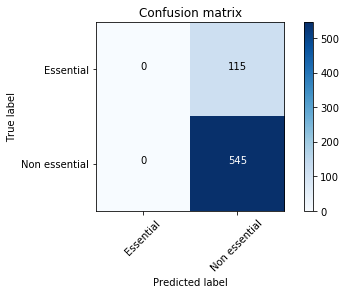

In [90]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Essential','Non essential'],normalize= False,  title='Confusion matrix')

In [91]:
print (classification_report(y_test, yhat))

precision    recall  f1-score   support

           0       0.83      1.00      0.90       545
           1       0.00      0.00      0.00       115

    accuracy                           0.83       660
   macro avg       0.41      0.50      0.45       660
weighted avg       0.68      0.83      0.75       660



### Predicting the probabilities for each gene to be essential or not

In [92]:
yprob=LR.predict_proba(X)# probability of cdc24 to be essential according this model
yprob[35]

array([0.85, 0.15])

In [93]:
data_remove_outliers['probability of being essential']=yprob[:,1]

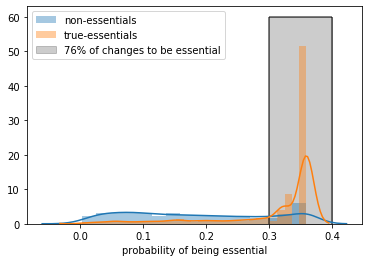

In [94]:
sns.distplot(data_remove_outliers[data_remove_outliers['Essentiality']==0]['probability of being essential'],label='non-essentials',norm_hist=True)
sns.distplot(data_remove_outliers[data_remove_outliers['Essentiality']==1]['probability of being essential'],label='true-essentials',norm_hist=True)
plt.vlines(x=0.3,ymin=0,ymax=60,linewidth=2,alpha=0.5)
plt.vlines(x=0.4,ymin=0,ymax=60,linewidth=2,alpha=0.5)
plt.hlines(y=60,xmin=0.3,xmax=0.4,linewidth=2,alpha=0.5)
plt.fill_between(x=[0.3, 0.4],y1=60,color='black',alpha=0.2,label='76% of changes to be essential')
plt.legend()

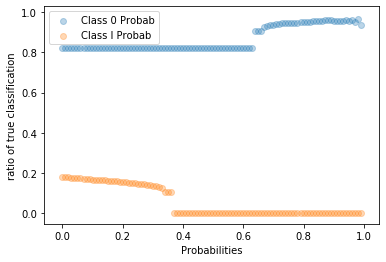

In [100]:
ratio_essentials=[]
ratio_nonessentials=[]
prob=np.arange(0,1,0.01)
for i in prob:
    ratio_essentials.append(np.sum(y[np.where(yprob[:,1]>i)[0]])/len(yprob[:,1]>i)) # the sum symbolizes the number of 1's which are the true essential proteins 
    ratio_nonessentials.append(1-np.sum(y[np.where(yprob[:,0]>i)[0]])/len(y[np.where(yprob[:,0]>i)[0]]))

plt.scatter(prob,ratio_nonessentials,alpha=0.3,label= 'Class 0 Probab')
plt.scatter(prob,ratio_essentials,alpha=0.3,label='Class I Probab')
plt.xlabel('Probabilities')
plt.ylabel('ratio of true classification')
plt.legend()

In [128]:
index_prone2essential=[]
bound=0.3
for i in np.arange(0,len(yprob)):
    if yprob[i,1] > bound : 
        index_prone2essential.append(i)
ratio_true_essentials=np.sum(data_remove_outliers.iloc[index_prone2essential,:]['Essentiality'])/data_remove_outliers['Essentiality'].value_counts()[1]

### Summary from the model

In [129]:
print('- The essential genes represents a ',data_remove_outliers['Essentiality'].value_counts()[1]/len(data_remove_outliers) * 100,'%', 'of the population of genes.')

print('- The ratio of true essentials contained in the genes that have more than',bound,'probability of being essential is =', ratio_true_essentials *100,'%.','This represents',(len(index_prone2essential))/len(data_remove_outliers) * 100,'%', 'of all genes. In other words, with this regression model we can trust that a gene has', ratio_true_essentials *100,'%' ,'changes of being essential if the probability given by the model is higher than',bound)


print('- For the genes that has less than ',bound,'Pr to be essential , then I can assure they are non essential, which are ', len(data_remove_outliers)-len(index_prone2essential),'genes. That represents the',(len(data_remove_outliers)-len(index_prone2essential))/data_remove_outliers['Essentiality'].value_counts()[0] * 100,'%','of the total number of non essential genes.')


- The essential genes represents a  17.96969696969697 % of the population of genes.
- The ratio of true essentials contained in the genes that have more than 0.3 probability of being essential is = 76.72849915682967 %. This represents 32.59090909090909 % of all genes. In other words, with this regression model we can trust that a gene has 76.72849915682967 % changes of being essential if the probability given by the model is higher than 0.3
- For the genes that has less than  0.3 Pr to be essential , then I can assure they are non essential, which are  4449 genes. That represents the 82.17584041374215 % of the total number of non essential genes.


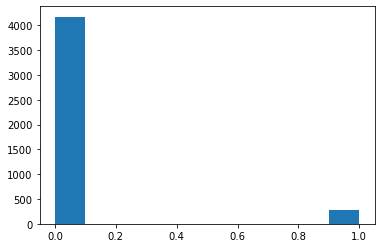

In [130]:
plt.hist(y[np.where(yprob[:,1]<0.3)]);

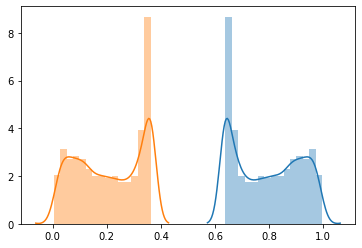

In [42]:
sns.distplot(yprob[:,0])
sns.distplot(yprob[:,1])